In [1]:
"""A basic MNIST example using JAX with the mini-libraries stax and optimizers.
The mini-library jax.example_libraries.stax is for neural network building, and
the mini-library jax.example_libraries.optimizers is for first-order stochastic
optimization.
"""

import time
import itertools
import tqdm

import numpy.random as npr

import jax.numpy as jnp
from jax import jit, grad, random
from jax.example_libraries import optimizers
from jax.example_libraries import stax
from jax.example_libraries.stax import Dense, Relu, LogSoftmax

In [2]:
# datasets.py
# Copyright 2018 The JAX Authors.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""Datasets used in examples."""


import array
import gzip
import os
from os import path
import struct
import urllib.request

import numpy as np


_DATA = "/tmp/jax_example_data/"


def _download(url, filename):
  """Download a url to a file in the JAX data temp directory."""
  if not path.exists(_DATA):
    os.makedirs(_DATA)
  out_file = path.join(_DATA, filename)
  if not path.isfile(out_file):
    urllib.request.urlretrieve(url, out_file)
    print(f"downloaded {url} to {_DATA}")


def _partial_flatten(x):
  """Flatten all but the first dimension of an ndarray."""
  return np.reshape(x, (x.shape[0], -1))


def _one_hot(x, k, dtype=np.float32):
  """Create a one-hot encoding of x of size k."""
  return np.array(x[:, None] == np.arange(k), dtype)


def mnist_raw():
  """Download and parse the raw MNIST dataset."""
  # CVDF mirror of http://yann.lecun.com/exdb/mnist/
  base_url = "https://storage.googleapis.com/cvdf-datasets/mnist/"

  def parse_labels(filename):
    with gzip.open(filename, "rb") as fh:
      _ = struct.unpack(">II", fh.read(8))
      return np.array(array.array("B", fh.read()), dtype=np.uint8)

  def parse_images(filename):
    with gzip.open(filename, "rb") as fh:
      _, num_data, rows, cols = struct.unpack(">IIII", fh.read(16))
      return np.array(array.array("B", fh.read()),
                      dtype=np.uint8).reshape(num_data, rows, cols)

  for filename in ["train-images-idx3-ubyte.gz", "train-labels-idx1-ubyte.gz",
                   "t10k-images-idx3-ubyte.gz", "t10k-labels-idx1-ubyte.gz"]:
    _download(base_url + filename, filename)

  train_images = parse_images(path.join(_DATA, "train-images-idx3-ubyte.gz"))
  train_labels = parse_labels(path.join(_DATA, "train-labels-idx1-ubyte.gz"))
  test_images = parse_images(path.join(_DATA, "t10k-images-idx3-ubyte.gz"))
  test_labels = parse_labels(path.join(_DATA, "t10k-labels-idx1-ubyte.gz"))

  return train_images, train_labels, test_images, test_labels


def mnist(permute_train=False):
  """Download, parse and process MNIST data to unit scale and one-hot labels."""
  train_images, train_labels, test_images, test_labels = mnist_raw()

  train_images = _partial_flatten(train_images) / np.float32(255.)
  test_images = _partial_flatten(test_images) / np.float32(255.)
  train_labels = _one_hot(train_labels, 10)
  test_labels = _one_hot(test_labels, 10)

  if permute_train:
    perm = np.random.RandomState(0).permutation(train_images.shape[0])
    train_images = train_images[perm]
    train_labels = train_labels[perm]

  return train_images, train_labels, test_images, test_labels

In [3]:
batch_size = 128
train_images, train_labels, test_images, test_labels = mnist()
num_train = train_images.shape[0]
num_complete_batches, leftover = divmod(num_train, batch_size)
num_batches = num_complete_batches + bool(leftover)

def data_stream():
  rng = npr.RandomState(0)
  while True:
    perm = rng.permutation(num_train)
    for i in range(num_batches):
      batch_idx = perm[i * batch_size:(i + 1) * batch_size]
      yield train_images[batch_idx], train_labels[batch_idx]

batches = data_stream()

In [6]:
rng = random.key(0)

step_size = 0.001
num_epochs = 20
momentum_mass = 0.9

opt_init, opt_update, get_params = optimizers.momentum(step_size, mass=momentum_mass)

def loss(params, batch):
    inputs, targets = batch
    preds = predict(params, inputs)
    return -jnp.mean(jnp.sum(preds * targets, axis=1))

def accuracy(params, batch):
    inputs, targets = batch
    target_class = jnp.argmax(targets, axis=1)
    predicted_class = jnp.argmax(predict(params, inputs), axis=1)
    return jnp.mean(predicted_class == target_class)

@jit
def update(i, opt_state, batch):
    params = get_params(opt_state)
    return opt_update(i, grad(loss)(params, batch), opt_state)

init_random_params, predict = stax.serial(
    Dense(1024),
    Relu,
    Dense(1024),
    Relu,
    Dense(10),
    LogSoftmax
)

_, init_params = init_random_params(rng, (-1, 28 * 28))
opt_state = opt_init(init_params)
itercount = itertools.count()

train_accs = []
test_accs = []
print("Starting training...")
for epoch in tqdm.trange(num_epochs):
    start_time = time.time()
    for _ in range(num_batches):
        opt_state = update(next(itercount), opt_state, next(batches))
    epoch_time = time.time() - start_time
    params = get_params(opt_state)
    train_accs.append(accuracy(params, (train_images, train_labels)))
    test_accs.append(accuracy(params, (test_images, test_labels)))
print("Training done.")

Starting training...


100%|██████████| 20/20 [00:06<00:00,  3.23it/s]

Training done.


In [8]:
test_accs[-1]

Array(0.9576, dtype=float32)

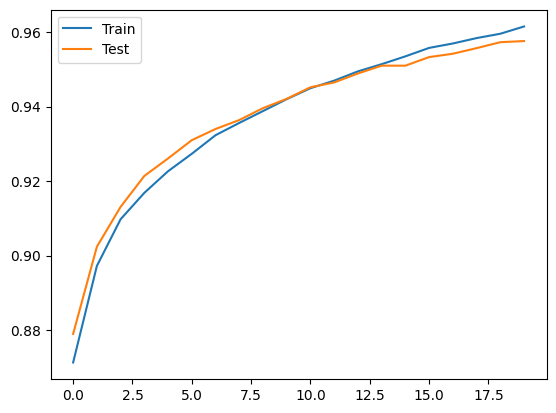

In [7]:
from matplotlib import pyplot as plt
plt.plot(train_accs, label='Train')
plt.plot(test_accs, label='Test')
plt.legend()
plt.show()